In [1]:
import os
import tensorflow as tf
print("tensorflow version = {}".format(tf.__version__))
print("keras version = {}".format(tf.keras.__version__))

tensorflow version = 2.4.1
keras version = 2.4.0


In [2]:
dataDir = 'rockpaperscissors'
os.listdir(dataDir)

['paper', 'README_rpc-cv-images.txt', 'rock', 'scissors']

In [3]:
import pathlib

image_count = len(list(pathlib.Path(dataDir).glob('*/*.PNG')))
print(image_count)

2188


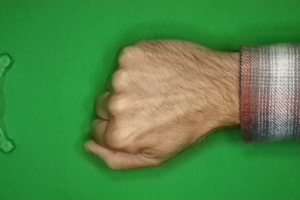

In [4]:
from PIL import Image

rock = list(pathlib.Path(dataDir).glob("rock/*"))
Image.open(str(rock[1]))

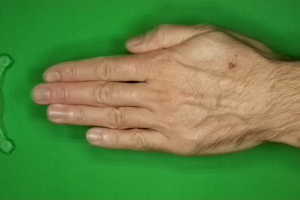

In [5]:
paper = list(pathlib.Path(dataDir).glob("paper/*"))
Image.open(str(paper[1]))

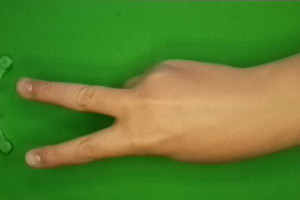

In [6]:
scissors = list(pathlib.Path(dataDir).glob("scissors/*"))
Image.open(str(scissors[1]))

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    validation_split = 0.4,
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range=0.2,
    fill_mode = 'nearest'
)

In [8]:
imgHeight = 150
imgWidth = 150

trainGenerator = datagen.flow_from_directory(
    dataDir,
    subset = "training",
    seed = 42,
    target_size = (imgHeight, imgWidth),    
)

valGenerator = datagen.flow_from_directory(
    dataDir,
    subset = "validation",
    seed = 42,
    target_size = (imgHeight, imgWidth),    
)
numClasses = trainGenerator.num_classes


Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [9]:
def generatorToTfdata(generator, input_shape):
    numClasses = generator.num_classes
    tfGenerator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None,
        input_shape[0],
        input_shape[1],
        input_shape[2]],
        [None, numClasses])
    )
    return tfGenerator

trainTfData = generatorToTfdata(trainGenerator, trainGenerator.image_shape)

valTfData = generatorToTfdata(valGenerator, valGenerator.image_shape)

In [10]:
print("type datagenerator: {}".format(type(trainGenerator)))
print("type ts_data: {}".format(type(trainTfData)))

type datagenerator: <class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>
type ts_data: <class 'tensorflow.python.data.ops.dataset_ops.FlatMapDataset'>


In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([
    layers.ZeroPadding2D(padding=(2, 2), input_shape=(150, 150, 3)),
    layers.Conv2D(16, (5, 5), strides=(1, 1), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu'),
    layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu'),
    layers.ZeroPadding2D(padding=(2, 2)),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(numClasses, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 154, 154, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 150, 150, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        1

In [12]:
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [13]:
callbacks = tf.keras.callbacks.TensorBoard(log_dir='./Graph')
history = model.fit(
      trainTfData,
      steps_per_epoch=10,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=45,
      validation_data=valTfData, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=1,
      callbacks=[callbacks])

Epoch 1/45
10/10 [==============================] - 27s 3s/step - loss: 1.0995 - accuracy: 0.3810 - val_loss: 1.0527 - val_accuracy: 0.4250
Epoch 2/45
10/10 [==============================] - 27s 3s/step - loss: 1.0016 - accuracy: 0.6286 - val_loss: 0.9637 - val_accuracy: 0.4875
Epoch 3/45
10/10 [==============================] - 22s 2s/step - loss: 0.8817 - accuracy: 0.6358 - val_loss: 0.7917 - val_accuracy: 0.6687
Epoch 4/45
10/10 [==============================] - 25s 3s/step - loss: 0.7309 - accuracy: 0.6993 - val_loss: 0.7095 - val_accuracy: 0.6938
Epoch 5/45
10/10 [==============================] - 19s 2s/step - loss: 0.6039 - accuracy: 0.8010 - val_loss: 0.5696 - val_accuracy: 0.7937
Epoch 6/45
10/10 [==============================] - 17s 2s/step - loss: 0.6248 - accuracy: 0.7702 - val_loss: 0.5302 - val_accuracy: 0.7899
Epoch 7/45
10/10 [==============================] - 17s 2s/step - loss: 0.6059 - accuracy: 0.7704 - val_loss: 0.5693 - val_accuracy: 0.7812
Epoch 8/45
10/10 [==

(0.0, 1.0)

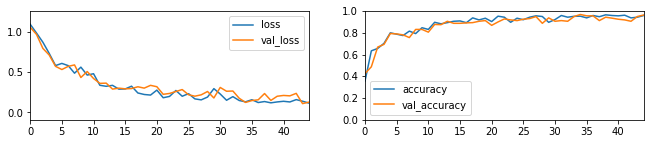

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axes = plt.subplots(1, 2, figsize=(11, 2))
ax = axes.ravel()

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])

ax[0].legend(['loss', 'val_loss'])
ax[0].set_xlim([0, len(history.history['loss'])-0.95])
ax[0].set_ylim([min(history.history['val_loss'])-0.2, max(history.history['val_loss'])+0.2])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])

ax[1].legend(['accuracy', 'val_accuracy'])
ax[1].set_xlim([0, len(history.history['accuracy'])-0.95])
ax[1].set_ylim([0, 1])

In [15]:
model.save_weights('weights.h5')